# Improving the architecture

Task:
2. Improve the architecture. Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy! Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image

In [ ]:
data = FashionMNIST(root="data/", download=True, train = True, transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=128,
                                          shuffle=True)
labels_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}
print(data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
train_data, val_data = random_split(data, [50000, 10000])
batch_size = 128
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(val_data))
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

test_data = FashionMNIST(root="data/", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)


length of Train Datasets:  50000
length of Validation Datasets:  10000


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, data_loader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            out, _ = model(images)
            loss = F.cross_entropy(out, labels)
            acc = accuracy(out, labels)
            outputs.append({'val_loss': loss, 'val_acc': acc})
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            images, labels = batch
            out, _ = model(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        print(f"Epoch [{epoch}], val_acc: {result['val_acc']:.4f}, val_loss: {result['val_loss']:.4f}")
        history.append(result)
    return history


## CNN

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128*3*3)
        # x = self.dropout(x)
        last_layer = F.relu(self.fc1(x))
        out = self.fc2(last_layer)
        return out, last_layer



In [ ]:
cnn = ImprovedCNN()
print(cnn)
loss_func = nn.CrossEntropyLoss()
loss_func
# unlike earlier example using optim.SGD, we use optim.Adam as the optimizer
# lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer
result0 = evaluate(cnn, val_loader)
print(result0)


ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
{'val_loss': 2.3030495643615723, 'val_acc': 0.10116693377494812}


In [ ]:
# for testing purpose, we calculate the accuracy of the initial
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        out, _ = cnn(images)
        _, predicted = torch.max(out, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    test_acc = correct / total
print('Test Accuracy of the model on the 10000 test images: %.2f' % (test_acc))

Test Accuracy of the model on the 10000 test images: 84.50


In [ ]:
# Training
history = fit(epochs=10, lr=0.01, model=cnn, train_loader=train_loader, val_loader=val_loader)


Epoch [0], val_acc: 0.8679, val_loss: 0.3613
Epoch [1], val_acc: 0.8719, val_loss: 0.3434
Epoch [2], val_acc: 0.8784, val_loss: 0.3444
Epoch [3], val_acc: 0.8769, val_loss: 0.3363
Epoch [4], val_acc: 0.8785, val_loss: 0.3334
Epoch [5], val_acc: 0.8794, val_loss: 0.3368
Epoch [6], val_acc: 0.8837, val_loss: 0.3206
Epoch [7], val_acc: 0.8815, val_loss: 0.3405
Epoch [8], val_acc: 0.8832, val_loss: 0.3366
Epoch [9], val_acc: 0.8841, val_loss: 0.3299


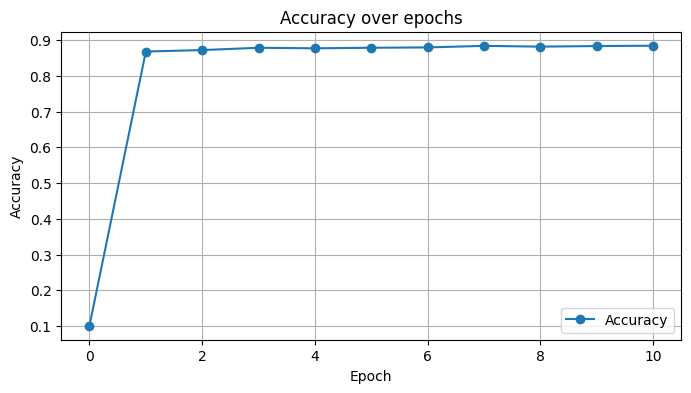

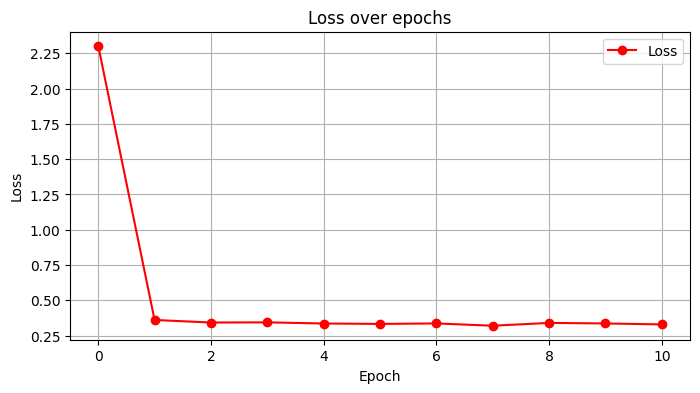

In [ ]:
history1 = [result0] + history

accuracies = [result['val_acc'] for result in history1]
losses = [result['val_loss'] for result in history1]

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(accuracies, '-o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(losses, '-o', color='red', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#testing
test_result = evaluate(cnn, test_loader)
print("Test accuracy:", test_result['val_acc'])

Test accuracy: 0.880859375


In [ ]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        out, _ = cnn(images)
        _, predicted = torch.max(out, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    test_acc = correct / total
print('Test Accuracy of the model on the 10000 test images: %.2f' % (test_acc * 100))


Test Accuracy of the model on the 10000 test images: 88.10


In [ ]:
sample = next(iter(test_loader))
imgs, lbls = sample

cnn.eval()
with torch.no_grad():
    outputs,_ = cnn(imgs[:10])

    pred_y = torch.max(outputs, 1)[1].cpu().numpy()
    actual_number = lbls[:10].cpu().numpy()

print(f'Prediction number: {pred_y}')
print(f'Actual number:     {actual_number}')


Prediction number: [9 2 1 1 6 1 4 4 5 7]
Actual number:     [9 2 1 1 6 1 4 6 5 7]
